In [2]:
import urllib.request
import urllib.request
import json
import pandas as pd
import json
client_id = "NjCkeE5n21b4IPWLlbAi"
client_secret = "J6RWn6YJz8"
# :반짝임: 필요한 입력값
start_date = "2024-06-23"
end_date = "2025-06-23"
keywords = ["상지건설"]
# :렌치: 요청 body 구성
body = {
    "startDate": start_date,
    "endDate": end_date,
    "timeUnit": "date",
    "keywordGroups": [
        {
            "groupName": keywords[0],
            "keywords": keywords
        }
    ],
    "device": "pc"
}
# :링크: API 요청
url = "https://openapi.naver.com/v1/datalab/search"
request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id", client_id)
request.add_header("X-Naver-Client-Secret", client_secret)
request.add_header("Content-Type", "application/json")
response = urllib.request.urlopen(request, data=json.dumps(body).encode("utf-8"))
rescode = response.getcode()
# :포장: 결과 확인
if rescode == 200:
    response_body = response.read()
else:
    print("Error Code:" + str(rescode))
# 네이버 API 응답 결과를 문자열로 받은 경우 (예: response_body.decode('utf-8'))
response_text = response_body.decode('utf-8')  # 너가 올린 JSON 문자열을 여기에 붙여넣거나 response_body.decode('utf-8') 대입
# JSON 문자열을 파이썬 객체로 변환
data_json = json.loads(response_text)
# 관심 데이터 추출
data_list = data_json['results'][0]['data']  # 첫 번째 키워드 그룹의 데이터
# DataFrame 생성
df = pd.DataFrame(data_list)
# 'period'를 datetime 형식으로 변환하고 인덱스로 지정
df['날짜'] = pd.to_datetime(df['period'])
df.drop(columns='period', inplace=True)
df.set_index('날짜', inplace=True)
df.head(3)

,ratio
날짜,
2024-06-23,0.02636
2024-06-24,0.10254
2024-06-25,0.15821


In [3]:
from pykrx import stock
import pandas as pd
from datetime import datetime
def get_daily_returns(ticker, start_date="2022-01-01", end_date=None, save_csv=True):
    """
    한국 주식 티커의 일일 수익률을 계산하여 DataFrame 및 CSV로 저장합니다.
    Parameters:
    - ticker: str, 예: "005930" (삼성전자)
    - start_date: str, "YYYY-MM-DD"
    - end_date: str, "YYYY-MM-DD" (기본: 오늘)
    - save_csv: bool, True면 CSV로 저장
    Returns:
    - DataFrame: 날짜별 수익률 포함
    """
    if end_date is None:
        end_date = datetime.today().strftime("%Y-%m-%d")
    # 1. 일별 OHLCV 데이터 가져오기
    df = stock.get_market_ohlcv_by_date(start_date, end_date, ticker)
    # 2. 2일 뒤 종가 대비 수익률 계산
    df['Return'] = df['종가'].shift(1) / df['종가'] - 1
    # 3. 날짜 인덱스 리셋
    df.reset_index(inplace=True)
    # 4. 필요한 컬럼만 정리
    df = df[['날짜', '종가', 'Return']]
    # 5. 저장
    if save_csv:
        filename = f"{ticker}_2days_later_return.csv"
        df.to_csv(filename, index=False)
        print(f"[✓] Saved to {filename}")
    return df
df1 = get_daily_returns("042940", start_date="2024-06-21")
print(df1.tail(3))

[✓] Saved to 042940_2days_later_return.csv
            날짜     종가    Return
239 2025-06-19  14640  0.060109
240 2025-06-20  13810  0.060101
241 2025-06-23  13250  0.042264


In [4]:
df_reset = df.reset_index()
# 2. 날짜 컬럼 형식 통일 (datetime)
df_reset['날짜'] = pd.to_datetime(df_reset['날짜'])
df1['날짜'] = pd.to_datetime(df1['날짜'])
# 3. 날짜 기준으로 병합 (inner join)
df2 = pd.merge(df1, df_reset, on='날짜', how='inner')
df2.tail(3)

,날짜,종가,Return,ratio
237,2025-06-18,15520,-0.005155,2.91532
238,2025-06-19,14640,0.060109,2.42894
239,2025-06-20,13810,0.060101,2.65748


:흰색_확인_표시: 시차별 상관관계:
     Lag  Correlation
0    -3     0.451259
1    -2     0.495707
2    -1     0.555941
3     0     0.592895
4     1     0.493656
5     2     0.430028
6     3     0.382108
7     4     0.293797
8     5     0.326348
9     6     0.294256
10    7     0.214569

:다트: 가장 높은 상관관계: lag 0일, 상관계수 = 0.5929


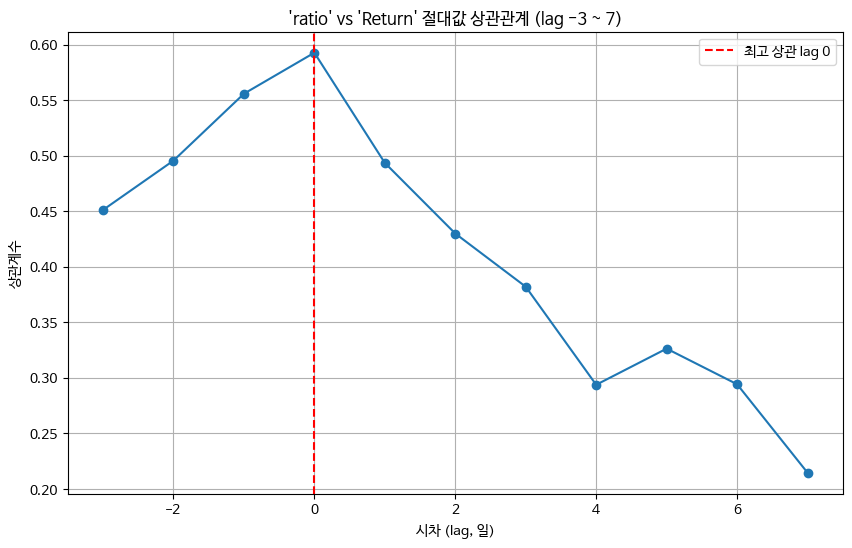

(    Lag  Correlation
 0    -3     0.451259
 1    -2     0.495707
 2    -1     0.555941
 3     0     0.592895
 4     1     0.493656
 5     2     0.430028
 6     3     0.382108
 7     4     0.293797
 8     5     0.326348
 9     6     0.294256
 10    7     0.214569,
 Lag            0.000000
 Correlation    0.592895
 Name: 3, dtype: float64)

In [6]:
import matplotlib.pyplot as plt

def lagged_correlation_analysis_return_ratio(df, ratio_col='ratio', return_col='Return', date_col='날짜', min_lag=-3, max_lag=7):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    lag_results = []
    for lag in range(min_lag, max_lag + 1):
        temp_df = df.copy()
        # 시차에 따라 Return 절대값 시프트 (음수 lag: 과거 시점, 양수 lag: 미래 시점)
        temp_df[f'{return_col}_lag_{lag}'] = temp_df[return_col].shift(-lag).abs()
        # ratio, shifted Return 둘 다 결측치 제거
        clean_df = temp_df.dropna(subset=[ratio_col, f'{return_col}_lag_{lag}'])
        corr = clean_df[ratio_col].corr(clean_df[f'{return_col}_lag_{lag}'])
        lag_results.append({'Lag': lag, 'Correlation': corr})
    lag_corr_df = pd.DataFrame(lag_results)
    best_row = lag_corr_df.loc[lag_corr_df['Correlation'].abs().idxmax()]
    print(":흰색_확인_표시: 시차별 상관관계:\n", lag_corr_df)
    print(f"\n:다트: 가장 높은 상관관계: lag {int(best_row['Lag'])}일, 상관계수 = {best_row['Correlation']:.4f}")
    plt.figure(figsize=(10,6))
    plt.plot(lag_corr_df['Lag'], lag_corr_df['Correlation'], marker='o', linestyle='-')
    plt.axvline(best_row['Lag'], color='red', linestyle='--', label=f"최고 상관 lag {int(best_row['Lag'])}")
    plt.title(f"'{ratio_col}' vs '{return_col}' 절대값 상관관계 (lag {min_lag} ~ {max_lag})")
    plt.xlabel("시차 (lag, 일)")
    plt.ylabel("상관계수")
    plt.legend()
    plt.grid(True)
    plt.show()
    return lag_corr_df, best_row
lagged_correlation_analysis_return_ratio(df2, ratio_col='ratio', return_col='Return', date_col='날짜', min_lag=-3, max_lag=7)